<a href="https://colab.research.google.com/github/ndb796/Captcha-Solver-Defense/blob/master/Captcha_Visualization_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/ndb796/Captcha-Solver-Defense.git

Cloning into 'Captcha-Solver-Defense'...
remote: Enumerating objects: 140010, done.
remote: Total 140010 (delta 0), reused 0 (delta 0), pack-reused 140010
Receiving objects: 100% (140010/140010), 1.02 GiB | 56.92 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (139998/139998), done.


In [0]:
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
import torchvision.transforms as transforms

NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
ALPHABET = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

ALL_CHAR_SET = NUMBER + ALPHABET
ALL_CHAR_SET_LEN = len(ALL_CHAR_SET)
MAX_CAPTCHA = 4

IMAGE_HEIGHT = 60
IMAGE_WIDTH = 160

TRAIN_DATASET_PATH = 'Captcha-Solver-Defense/dataset' + os.path.sep + 'train'
TEST_DATASET_PATH = 'Captcha-Solver-Defense/dataset' + os.path.sep + 'test'
PREDICT_DATASET_PATH = 'Captcha-Solver-Defense/dataset' + os.path.sep + 'predict'

TRAIN_DATASET_COUNT = 120000
TEST_DATASET_COUNT = 20000

TRAIN_BATCH_SIZE = 256
TEST_BATCH_SIZE = 128

def encode(text):
    vector = np.zeros(ALL_CHAR_SET_LEN * MAX_CAPTCHA, dtype=float)
    def char2pos(c):
        if c =='_':
            k = 62
            return k
        k = ord(c)-48
        if k > 9:
            k = ord(c) - 65 + 10
            if k > 35:
                k = ord(c) - 97 + 26 + 10
                if k > 61:
                    raise ValueError('error')
        return k
    for i, c in enumerate(text):
        idx = i * ALL_CHAR_SET_LEN + char2pos(c)
        vector[idx] = 1.0
    return vector

def decode(vec):
    char_pos = vec.nonzero()[0]
    text=[]
    for i, c in enumerate(char_pos):
        char_at_pos = i
        char_idx = c % ALL_CHAR_SET_LEN
        if char_idx < 10:
            char_code = char_idx + ord('0')
        elif char_idx <36:
            char_code = char_idx - 10 + ord('A')
        elif char_idx < 62:
            char_code = char_idx - 36 + ord('a')
        elif char_idx == 62:
            char_code = ord('_')
        else:
            raise ValueError('error')
        text.append(chr(char_code))
    return "".join(text)

class MyDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.train_image_file_paths = [os.path.join(folder, image_file) for image_file in os.listdir(folder)]
        self.transform = transform

    def __len__(self):
        return len(self.train_image_file_paths)

    def __getitem__(self, idx):
        image_root = self.train_image_file_paths[idx]
        image_name = image_root.split(os.path.sep)[-1]
        image = Image.open(image_root)
        if self.transform is not None:
            image = self.transform(image)
        label = encode(image_name.split('_')[0])
        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),
])

def get_train_data_loader():
    dataset = MyDataset(TRAIN_DATASET_PATH, transform=transform)
    return DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

def get_test_data_loader():
    dataset = MyDataset(TEST_DATASET_PATH, transform=transform)
    return DataLoader(dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)

In [0]:
adv_dataset_train_path = 'adv_dataset/train'
adv_dataset_test_path = 'adv_dataset/test'

if not os.path.exists(adv_dataset_train_path):
    os.makedirs(adv_dataset_train_path)

if not os.path.exists(adv_dataset_test_path):
    os.makedirs(adv_dataset_test_path)

In [0]:
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
import torchvision
import numpy as np
import copy
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import hashlib

class RES50(nn.Module):
    def __init__(self):
        super(RES50, self).__init__()
        self.num_cls = MAX_CAPTCHA * ALL_CHAR_SET_LEN
        self.base = torchvision.models.resnet50(pretrained=False)
        self.base.fc = nn.Linear(self.base.fc.in_features, self.num_cls)
    def forward(self, x):
        out = self.base(x)
        return out

class LinfPGDAttack(object):
    def __init__(self, model, epsilon=0.1, k=7, a=0.03, random_start=True):
        self.model = model
        self.epsilon = epsilon
        self.k = k
        self.a = a
        self.random_start = random_start
        self.loss_fn = nn.MultiLabelSoftMarginLoss()

    def perturb(self, x_natural, y):
        if self.random_start:
            x = x_natural + np.random.uniform(-self.epsilon, self.epsilon, x_natural.shape).astype('float32')
        else:
            x = np.copy(x_natural)
        for i in range(self.k):
            x_var = Variable(torch.from_numpy(x).to(device), requires_grad=True)
            y_var = Variable(y, requires_grad=True)
            scores = self.model(x_var)
            loss = self.loss_fn(scores, y_var)
            loss.backward()
            grad = x_var.grad.data.cpu().numpy()
            x += self.a * np.sign(grad)
            x = np.clip(x, x_natural - self.epsilon, x_natural + self.epsilon)
            x = np.clip(x, 0, 1)
        return x

def attack(x, y, model, adversary):
    model_copied = copy.deepcopy(model)
    for parameter in model_copied.parameters():
        parameter.requires_grad = False
    model_copied.eval()
    adversary.model = model_copied
    x_adv = adversary.perturb(x.numpy(), y)
    return torch.from_numpy(x_adv)

use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('Cuda Available')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 80
learning_rate = 0.0005

def test():
    print("[ Test Mode ]")
    cnn = RES50()
    cnn = torch.nn.DataParallel(cnn)
    cnn.to(device)
    cnn.eval()
    cnn.load_state_dict(torch.load("Captcha-Solver-Defense/model_pgd_delayed_weak_3.pkl"))

    print("[ Model Loaded ]")
    criterion = nn.MultiLabelSoftMarginLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
    adversary = LinfPGDAttack(model=cnn)
    test_data_loader = get_test_data_loader()

    correct = 0
    total = 0
    t0 = time.time()
    count = 0
    total_loss = 0.0

    for i, (images, labels) in enumerate(test_data_loader):
        temp_labels = Variable(labels.float()).to(device)
        images_adv = attack(images, temp_labels, cnn, adversary)
        images_adv_var = Variable(images_adv).to(device)
        predict_labels = cnn(images_adv_var).to(device)

        temp_labels = Variable(labels.float()).to(device)
        loss = criterion(predict_labels, temp_labels)

        total_loss += loss.item()
        count += 1

        current_batch_size = labels.size(0)

        for k in range(current_batch_size):
            predict_label = predict_labels[k]
            c0 = ALL_CHAR_SET[np.argmax(predict_label[0:ALL_CHAR_SET_LEN].data.cpu().numpy())]
            c1 = ALL_CHAR_SET[np.argmax(predict_label[ALL_CHAR_SET_LEN:2 * ALL_CHAR_SET_LEN].data.cpu().numpy())]
            c2 = ALL_CHAR_SET[np.argmax(predict_label[2 * ALL_CHAR_SET_LEN:3 * ALL_CHAR_SET_LEN].data.cpu().numpy())]
            c3 = ALL_CHAR_SET[np.argmax(predict_label[3 * ALL_CHAR_SET_LEN:4 * ALL_CHAR_SET_LEN].data.cpu().numpy())]
            true_label = decode(labels.numpy()[k])

            print(true_label)
            hash_object = hashlib.md5(true_label.encode())
            name = true_label + '_' + hash_object.hexdigest() + '.png'

            print(images_adv[k].shape)
            file_name = adv_dataset_test_path + '/' + name
            print(file_name)
            save_image(images_adv[k], file_name)

            plt.imshow(images_adv[k].permute(1, 2, 0))
            plt.show()

            predict_label = '%s%s%s%s' % (c0, c1, c2, c3)
            if predict_label == true_label:
                correct += 1

        total += current_batch_size

    print("Total Test Accuracy of the model on the %d test images: %f %%" % (total, 100 * correct / total))
    print("Time Spent:", time.time() - t0)
    print("Average Loss:", total_loss / count)

Cuda Available


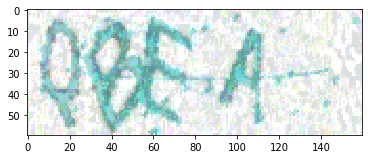

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(adv_dataset_test_path + '/QBEA_11a868b9eca1c438ed02c0ae75e7574e.png')
plt.imshow(img)
plt.show()